In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict, List, Tuple
from pathlib import Path
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
from tqdm import tqdm
from contextlib import contextmanager
from time import time
from collections import Counter

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import lightgbm as lgb

from mykaggle.metric.mse import rmsle
from mykaggle.util.ml_logger import MLLogger
from mykaggle.lib.lgbm_util import compute_importances, save_importances
from mykaggle.lib.pandas_util import change_column_name
from mykaggle.util.routine import fix_seed

sns.set_style('darkgrid')

In [3]:
settings = yaml.safe_load('''
name: '218_eda'
competition: atmacup8
seed: 1019
training:
    num_folds: 5
    num_rounds: 1000
    early_stopping_rounds: 100
    verbose_eval: 20
lgbm_params:
    objective: binary
    learning_rate: 0.05
    max_depth: -1
    num_leaves: 31
    colsample_bytree: .7
    metric: "None"
feature:
    name_bow_pca_dim: 10
    name_bow_word_th1: 5
    name_bow_word_th2: 3
    name_bow_th1_upper: 130
    name_bow_th2_upper: 1000
''')

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
fix_seed(settings['seed'])
pd.set_option('display.max_rows', 500)

In [5]:
datadir = Path('../data/')
ckptdir = Path('../ckpt/') / settings['name']
if not ckptdir.exists():
    ckptdir.mkdir()

In [6]:
df_train = pd.read_csv(datadir / 'id_train.csv')
df_test = pd.read_csv(datadir / 'id_test_unknown1.csv')
df_submission = pd.read_csv(datadir / 'atmaCup8_sample-submission.csv')
df_train.shape, df_test.shape

((8358, 17), (8360, 12))

In [7]:
df_train.head().T

,0,1,2,3,4
Name,LEGO Batman: The Videogame,LEGO Indiana Jones: The Original Adventures,LEGO Batman: The Videogame,Combat,LEGO Harry Potter: Years 5-7
Platform,Wii,Wii,PSP,2600,Wii
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Warner Bros. Interactive Entertainment,LucasArts,Warner Bros. Interactive Entertainment,Atari,Warner Bros. Interactive Entertainment
NA_Sales,180,151,56,117,69
EU_Sales,97,61,44,7,42
JP_Sales,0,0,0,0,0
Other_Sales,28,21,27,1,12
Global_Sales,306,234,128,125,124


In [8]:
df_train2 = pd.read_csv(datadir / 'country_train.csv')
df_train2.loc[df_train2['Platform'] == 'DS', 'Year_of_Release'].head(12)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


11         NaN
26         NaN
30         NaN
31         NaN
33         NaN
35         NaN
56         NaN
57         NaN
71         NaN
78         NaN
2413    2004.0
2421    2004.0
Name: Year_of_Release, dtype: float64

In [9]:
df_test.head().T

,0,1,2,3,4
Name,Hitman 2: Silent Assassin,Legacy of Kain: Soul Reaver,Metal Gear Solid 2: Substance,Silent Hill: Homecoming,Silent Hill: Homecoming
Platform,XB,PS,XB,X360,PS3
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Eidos Interactive,Eidos Interactive,Konami Digital Entertainment,Konami Digital Entertainment,Konami Digital Entertainment
Critic_Score,84,91,87,70,71
Critic_Count,23,17,28,54,41
User_Score,8,9,8.5,6.9,6.9
User_Count,19,132,39,180,143
Developer,Io Interactive,Crystal Dynamics,KCEJ,Double Helix Games,Double Helix Games


In [10]:
df_submission.head()

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Global_Sales
0,63.371815
1,63.371815
2,63.371815
3,63.371815
4,63.371815


In [11]:
df_train.loc[:, 'has_na_sales'] = df_train.loc[:, 'NA_Sales']  > 0
df_train.loc[:, 'has_eu_sales'] = df_train.loc[:, 'EU_Sales']  > 0
df_train.loc[:, 'has_jp_sales'] = df_train.loc[:, 'JP_Sales']  > 0
df_train.loc[:, 'has_other_sales'] = df_train.loc[:, 'Other_Sales']  > 0
# df_train.to_csv(datadir / 'country_train.csv', index=False)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# 要検討
df_best_pred = pd.read_csv('../ckpt/187_name_count/187_name_count.csv')
df_test.loc[:, 'Global_Sales'] = df_best_pred.loc[:, 'Global_Sales']

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
train = df_train.copy()
test = df_test.copy()
train['is_test'] = False
test['is_test'] = True
df_whole = pd.concat([train, test])

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
train_others = {
    'main': df_train.copy(),
    'another': df_test.copy()
}
test_others = {
    'main': df_test.copy(),
    'another': df_train.copy(),
}

# Year_of_Release の外れ値探す

In [14]:
df_train[df_train['Platform'] == 'DS']['Year_of_Release'].min()

2004.0

In [15]:
# 元の値を記録しておく
df_old_train = pd.read_csv(datadir / 'train.csv')
df_old_train.iloc[[169], :]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
169,Strongest Tokyo University Shogi DS,DS,1985.0,Action,Mycom,0,0,2,0,2,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_train[df_train['Platform'] == 'DS'].head(12)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,...,Critic_Count,User_Score,User_Count,Developer,Rating,id,has_na_sales,has_eu_sales,has_jp_sales,has_other_sales
11,LEGO Harry Potter: Years 5-7,DS,NaN,Action,Warner Bros. Interactive Entertainment,34,25,0,7,66,...,4.0,tbd,NaN,Traveller's Tales,E10+,11,True,True,False,True
26,Happy Feet Two,DS,NaN,Action,Warner Bros. Interactive Entertainment,8,1,0,1,10,...,NaN,tbd,NaN,WayForward,E,26,True,True,False,True
30,Tornado,DS,NaN,Action,Ignition Entertainment,7,0,0,0,7,...,26.0,tbd,NaN,Skonec,E,30,True,False,False,False
31,Alex Rider: Stormbreaker,DS,NaN,Action,THQ,6,0,0,0,7,...,11.0,6.1,10.0,Altron,T,31,True,False,False,False
33,Captain America: Super Soldier,DS,NaN,Action,Sega,5,0,0,0,5,...,NaN,NaN,NaN,NaN,NaN,33,True,False,False,False
35,Runaway: A Twist of Fate,DS,NaN,Adventure,Focus Home Interactive,0,2,0,0,2,...,5.0,NaN,NaN,Pendulo Studios,T,35,False,True,False,False
56,Egg Monster Hero,DS,NaN,Role-Playing,Square Enix,0,0,9,0,9,...,NaN,NaN,NaN,Neverland,E,56,False,False,True,False
57,Mega Man Battle Network: Operation Shooting Star,DS,NaN,Role-Playing,Capcom,0,0,7,0,7,...,NaN,NaN,NaN,NaN,NaN,57,False,False,True,False
71,Jet Impulse,DS,NaN,Simulation,Nintendo,0,0,2,0,2,...,NaN,NaN,NaN,NaN,NaN,71,False,False,True,False
78,Advance Wars: Days of Ruin,DS,NaN,Strategy,Nintendo,43,12,0,5,61,...,55.0,8.7,96.0,Intelligent Systems,E10+,78,True,True,False,True


In [40]:
df_train = pd.read_csv(datadir / 'id_train_old.csv')
df_train.loc[[169], ['Year_of_Release']] = np.nan
if df_train[df_train['Platform'] == 'DS']['Year_of_Release'].min() != 1985.0:
    print('succeed')
    df_train.to_csv(datadir / 'id_train.csv', index=False)

succeed


In [41]:
df_train = pd.read_csv(datadir / 'country_prob_train_old.csv')
df_train.loc[[169], ['Year_of_Release']] = np.nan
if df_train[df_train['Platform'] == 'DS']['Year_of_Release'].min() != 1985.0:
    print('succeed')
    df_train.to_csv(datadir / 'country_prob_train.csv', index=False)

succeed


In [42]:
df_train = pd.read_csv(datadir / 'country_train_old.csv')
df_train.loc[[169], ['Year_of_Release']] = np.nan
if df_train[df_train['Platform'] == 'DS']['Year_of_Release'].min() != 1985.0:
    print('succeed')
    df_train.to_csv(datadir / 'country_train.csv', index=False)

succeed


In [60]:
# ほかも見とく

In [66]:
pd.set_option('display.max_columns', 100)
platform_year = df_train.pivot_table(index='Platform', columns='Year_of_Release', values='Name', aggfunc='count')
platform_year = platform_year.fillna(0)
platform_year

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Year_of_Release,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,1988.0,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0
Platform,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2600,4.0,34.0,23.0,8.0,0.0,0.0,2.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3DO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3DS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,48.0,49.0,37.0,50.0,27.0,0.0
DC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,12.0,14.0,7.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,70.0,114.0,192.0,260.0,197.0,160.0,70.0,14.0,5.0,0.0,0.0,0.0,0.0
GB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,2.0,8.0,7.0,0.0,3.0,4.0,5.0,5.0,5.0,8.0,10.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GBA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,95.0,96.0,105.0,67.0,23.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,58.0,73.0,42.0,38.0,17.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
platform_year.loc['Wii', :].reset_index()

,Year_of_Release,Wii
0,1980.0,0.0
1,1981.0,0.0
2,1982.0,0.0
3,1983.0,0.0
4,1984.0,0.0
5,1985.0,0.0
6,1986.0,0.0
7,1987.0,0.0
8,1988.0,0.0
9,1989.0,0.0


/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


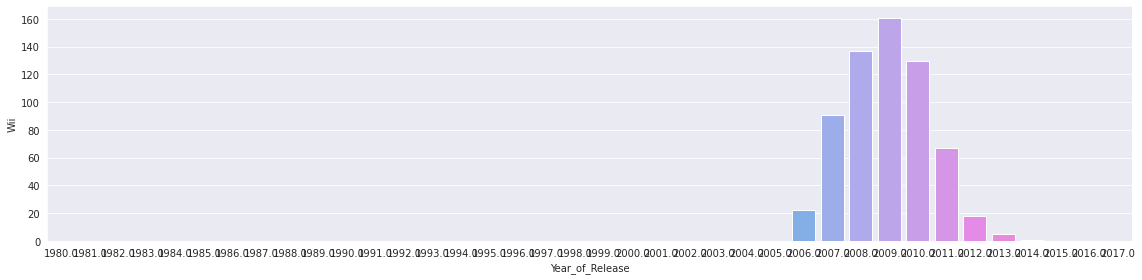

In [86]:
plt.figure(figsize=(16, 4))
sns.barplot(data=platform_year.loc['Wii', :].reset_index(), x='Year_of_Release', y='Wii')
plt.tight_layout()

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


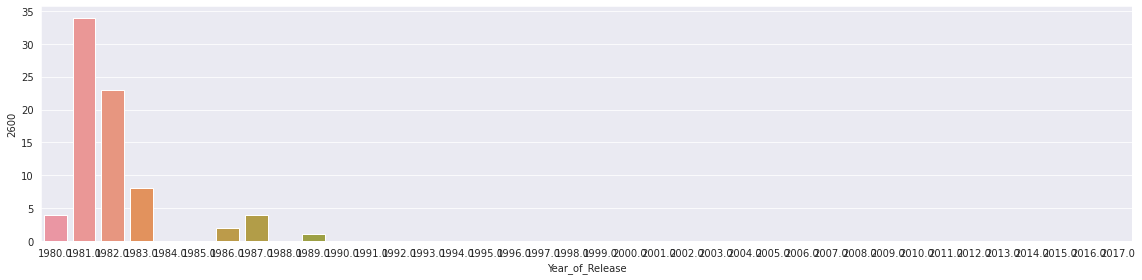

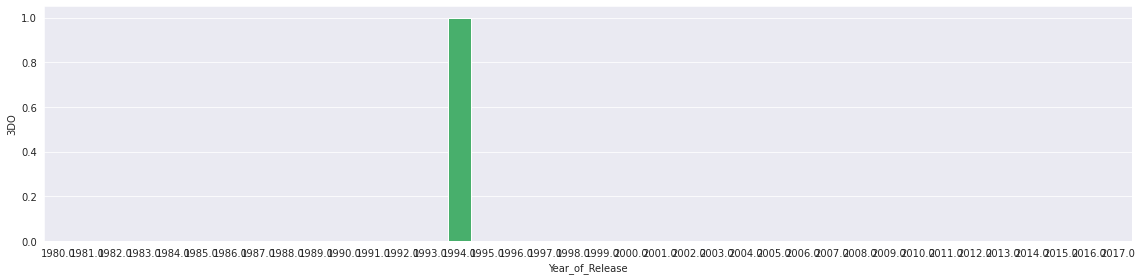

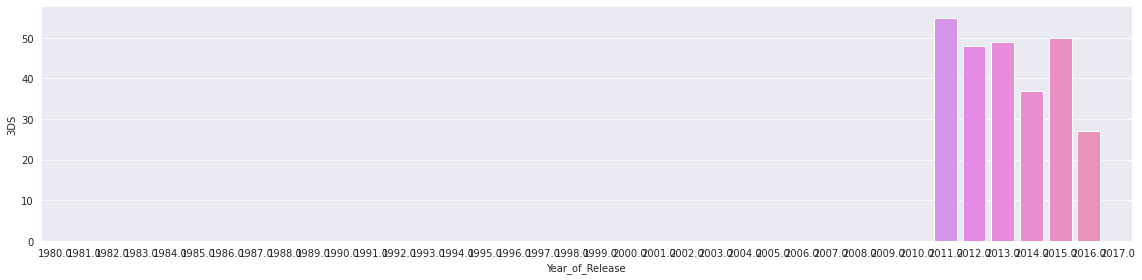

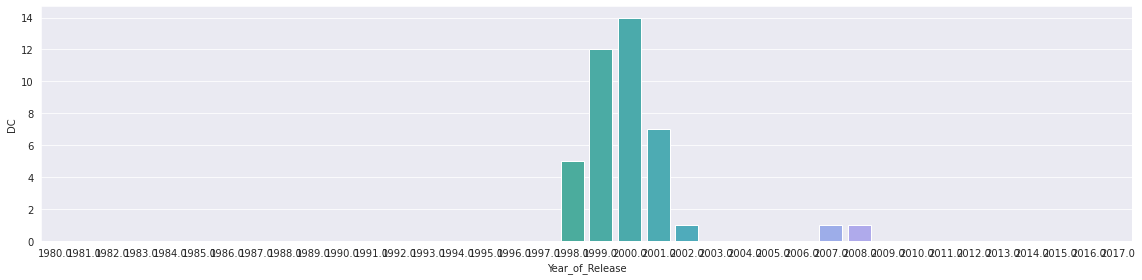

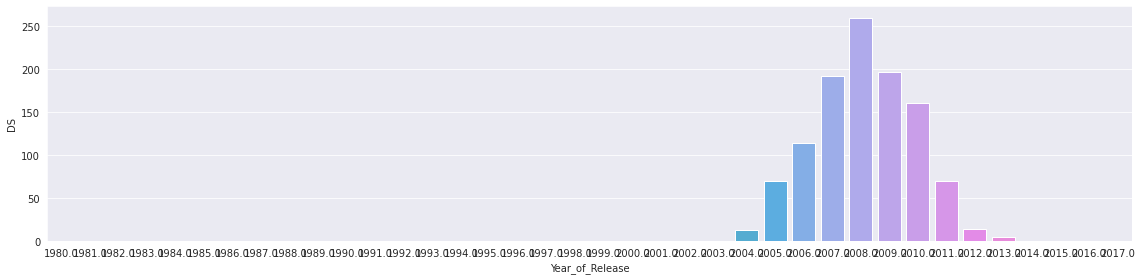

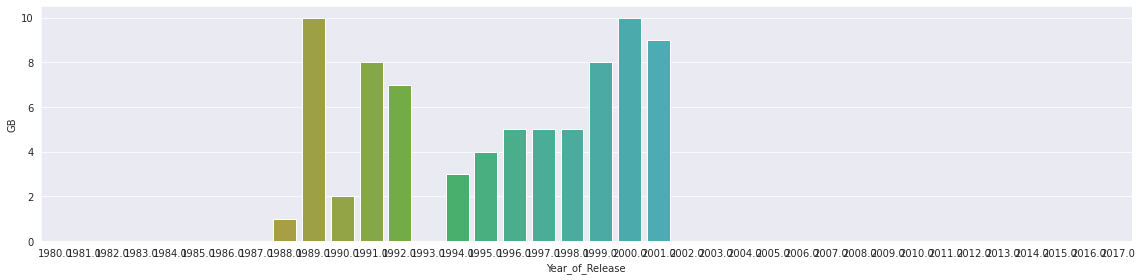

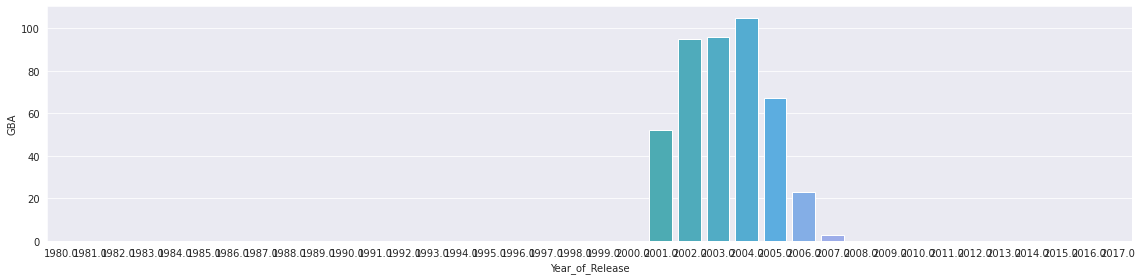

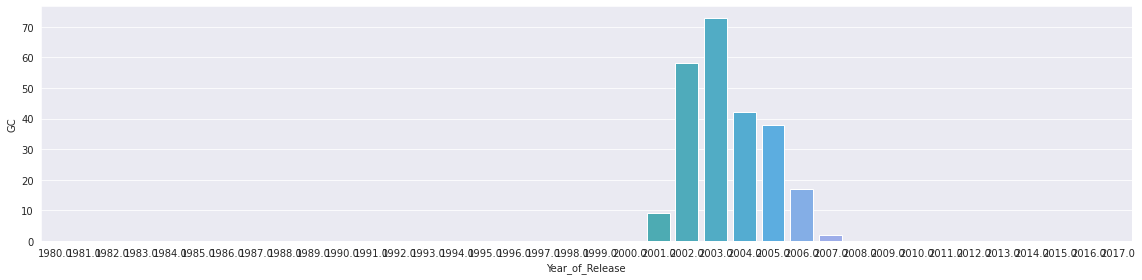

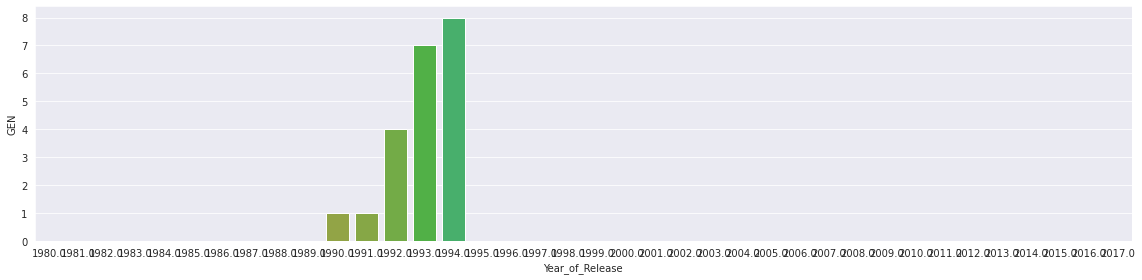

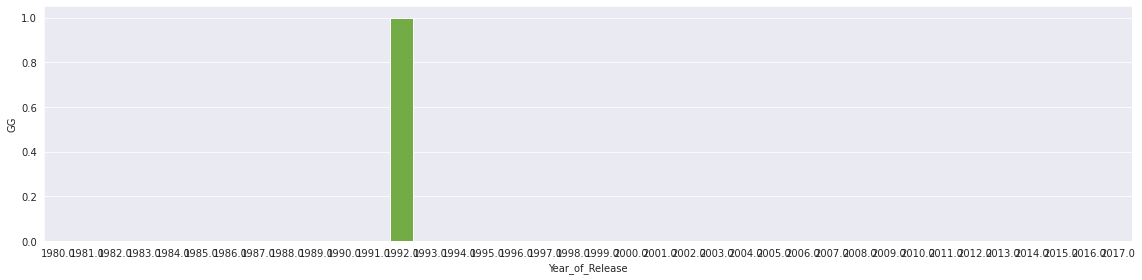

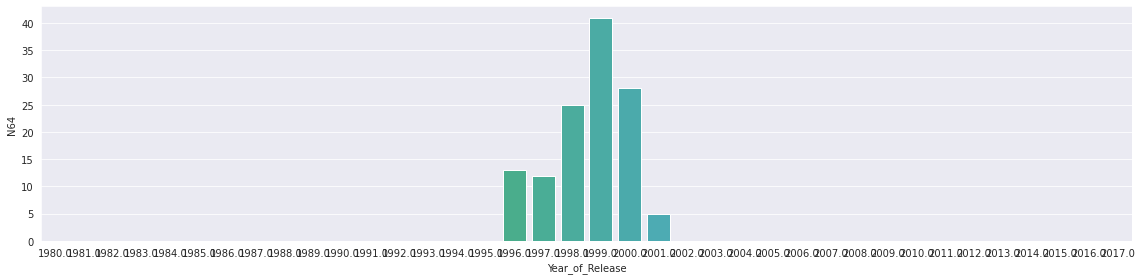

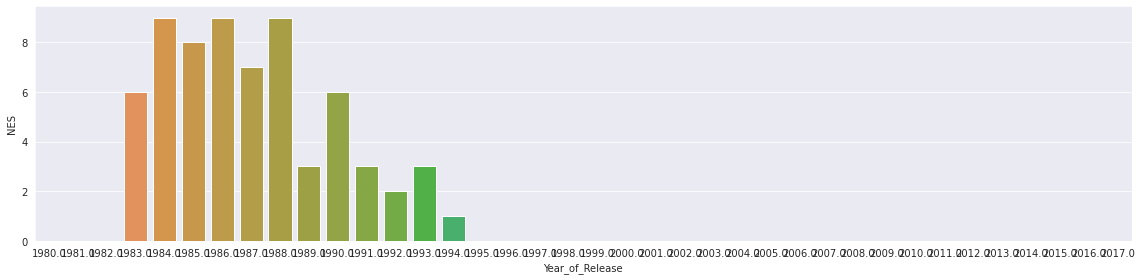

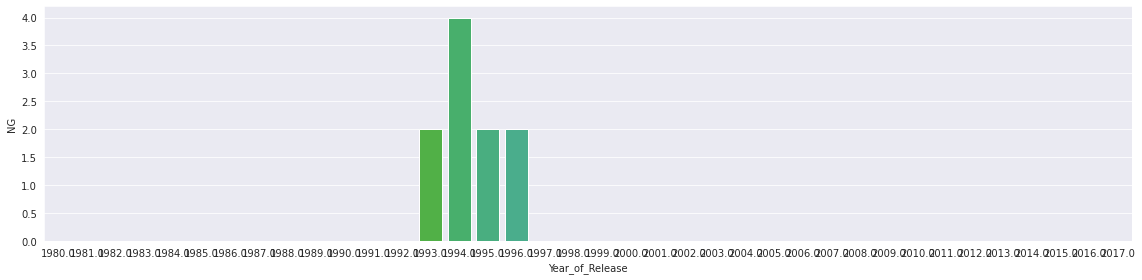

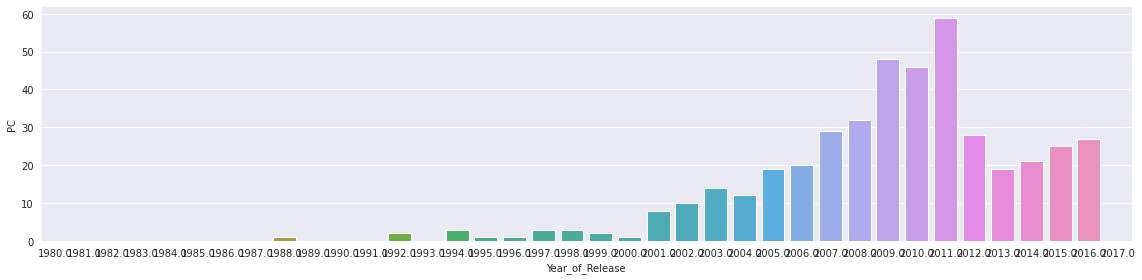

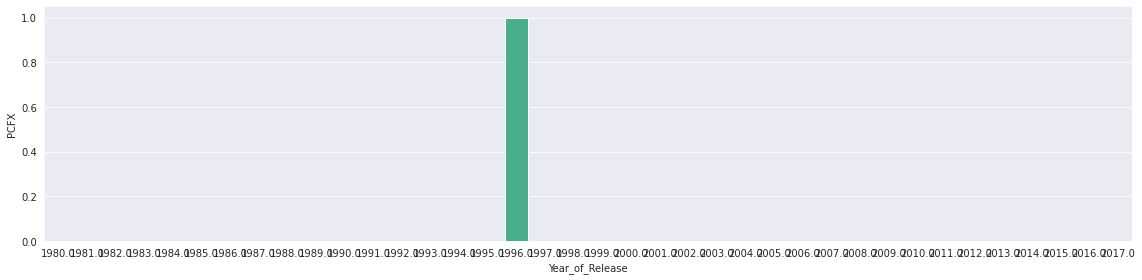

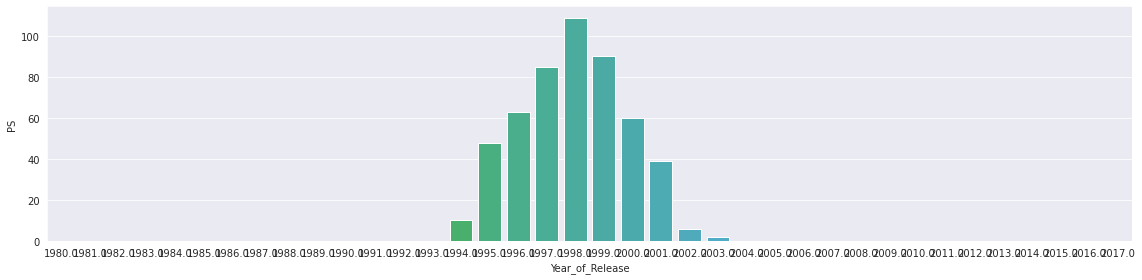

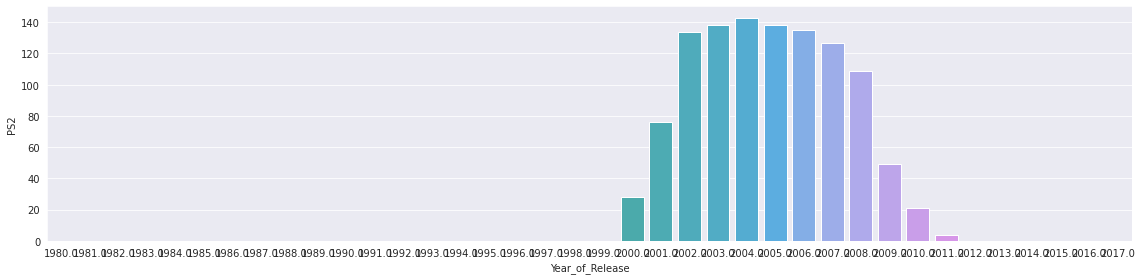

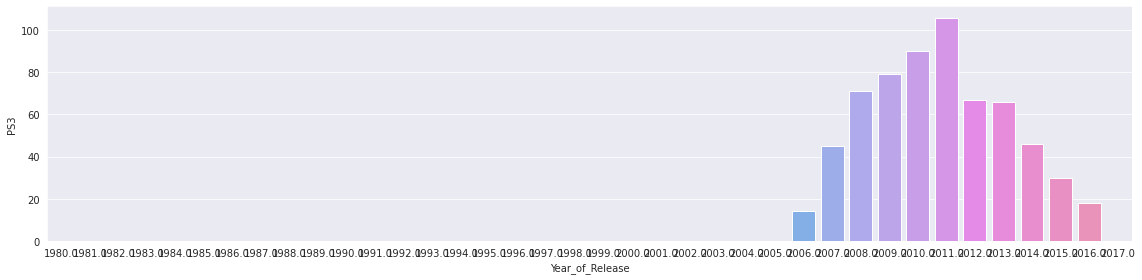

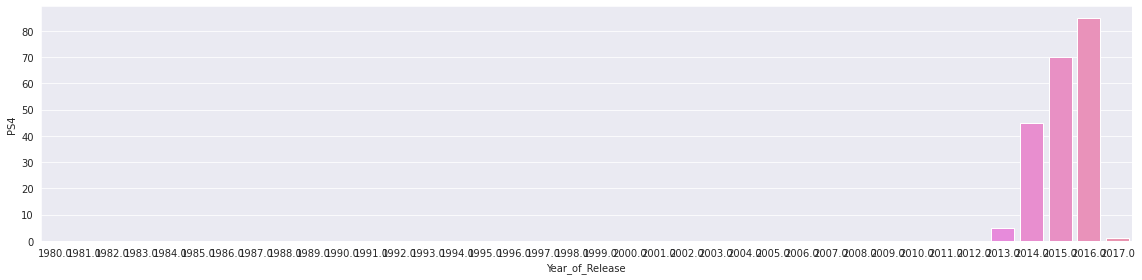

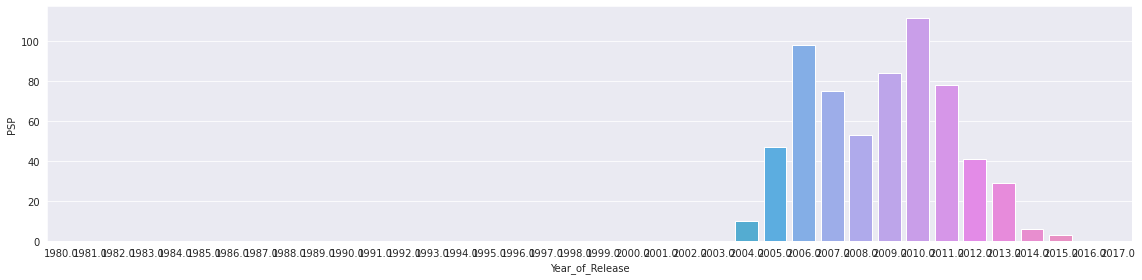

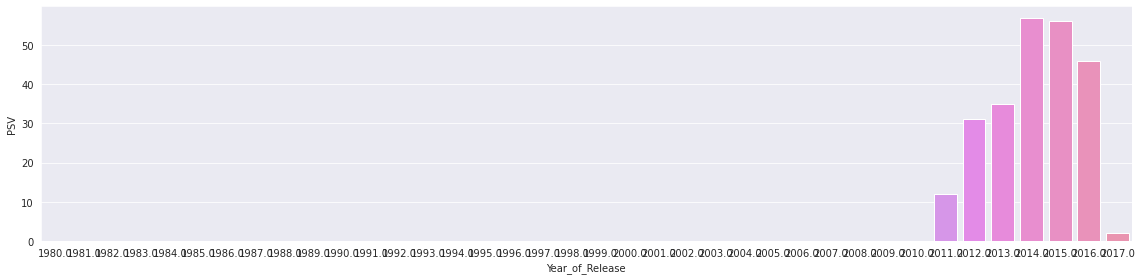

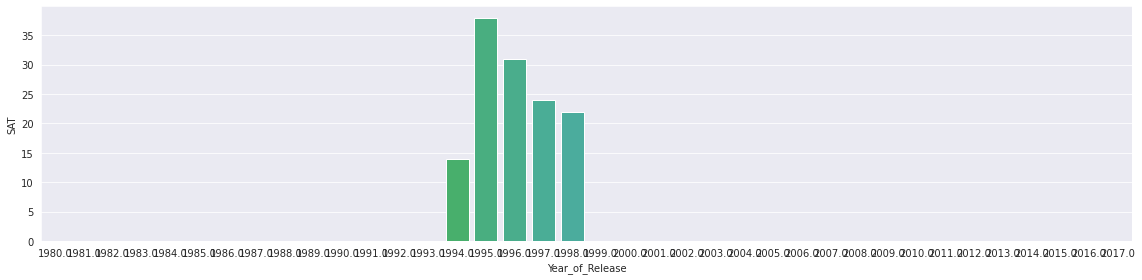

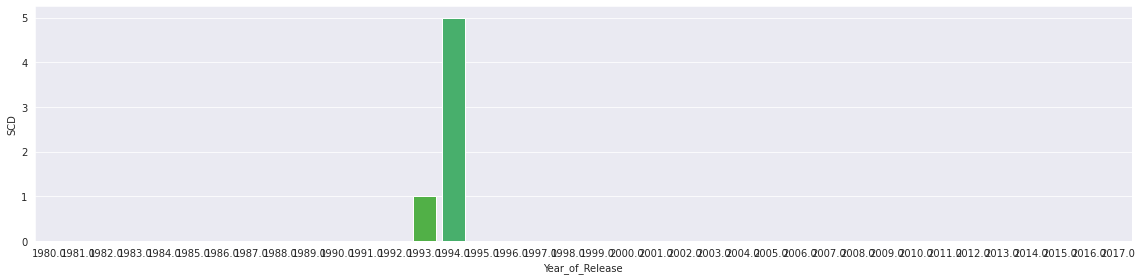

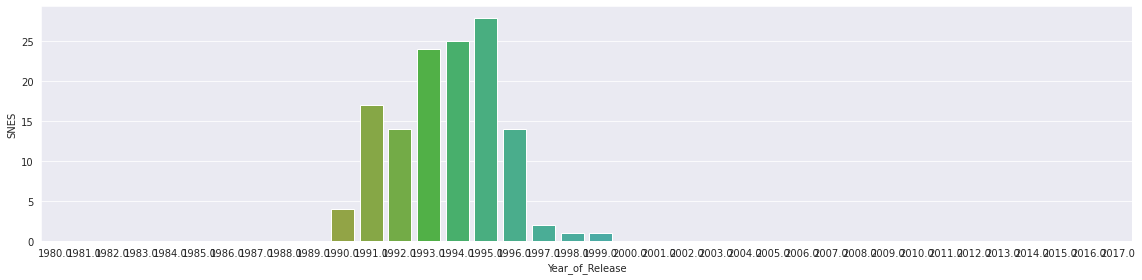

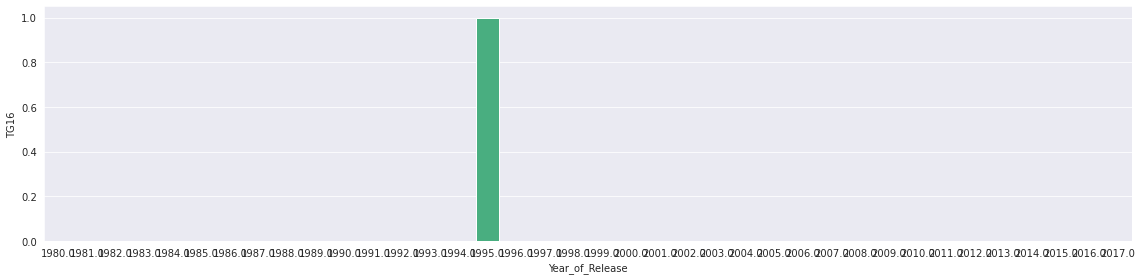

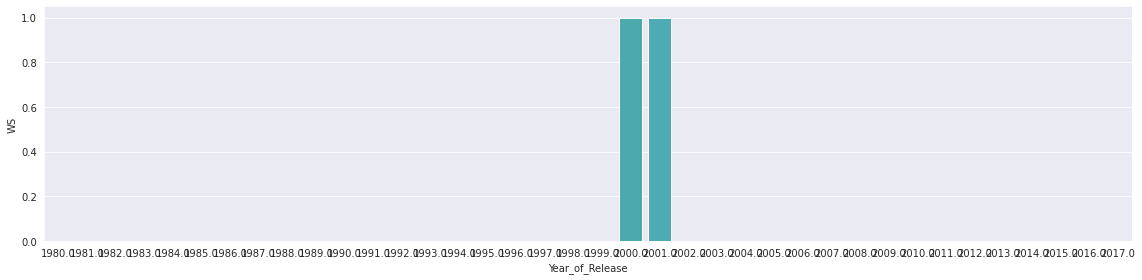

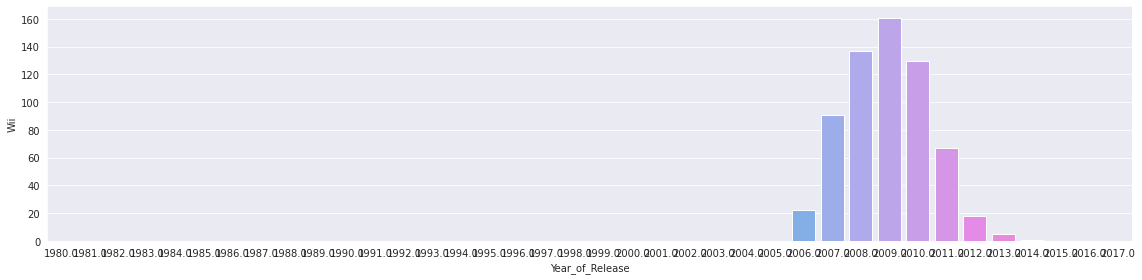

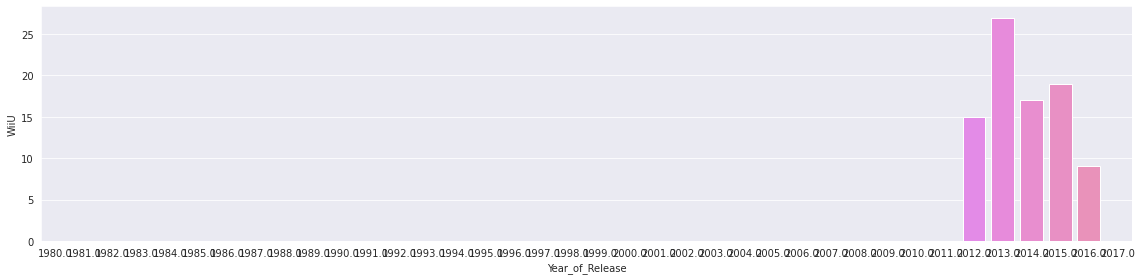

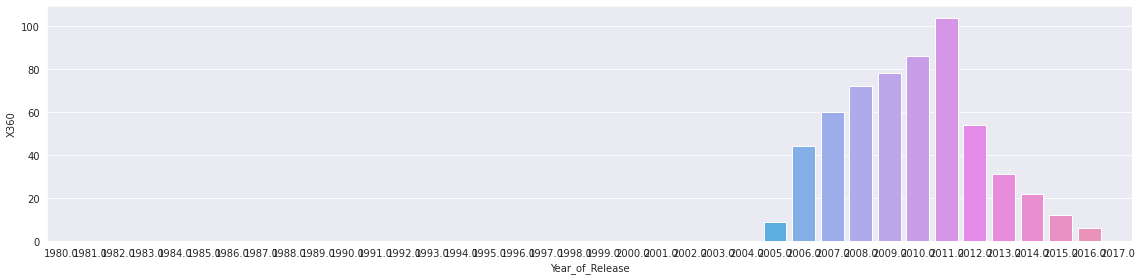

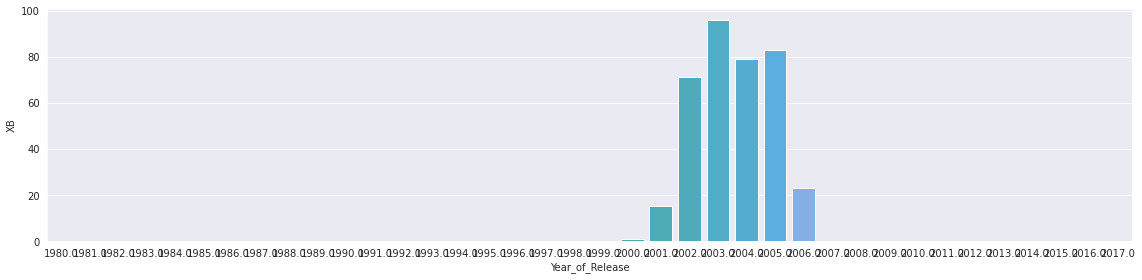

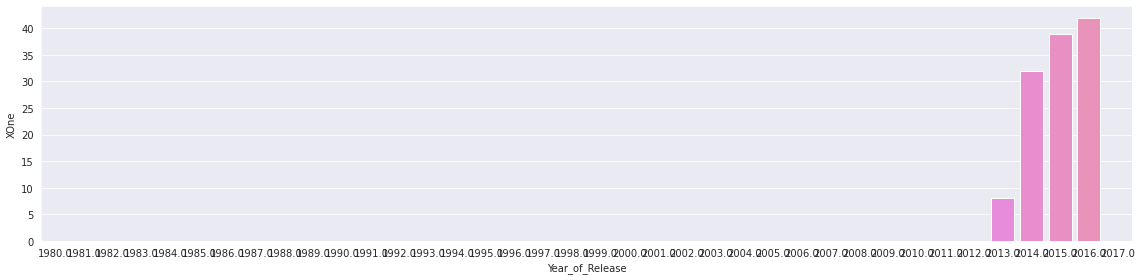

In [87]:
platforms = list(platform_year.index)
for p in platforms:
    plt.figure(figsize=(16, 4))
    sns.barplot(data=platform_year.loc[p, :].reset_index(), x='Year_of_Release', y=p)
    plt.tight_layout()

# User Score など

In [50]:
df_train['is_User_Score_tbd'] = df_train['User_Score'].apply(lambda x: x == 'tbd')

In [52]:
df_train_score = df_train[~df_train['is_User_Score_tbd']]
df_train_score['User_Score'] = df_train_score['User_Score'].astype(float)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [94]:
# rating system がはじまったのはいつから?
columns = [
    'User_Score', 'User_Count', 'Critic_Score', 'Critic_Count',
    'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'
]
df_train_score.groupby('Year_of_Release')[columns].mean()

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,User_Score,User_Count,Critic_Score,Critic_Count,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Year_of_Release,,,,,,,,,
1980.0,NaN,NaN,NaN,NaN,194.250000,12.250000,0.000000,2.250000,208.750000
1981.0,NaN,NaN,NaN,NaN,68.352941,4.029412,0.000000,0.676471,73.264706
1982.0,NaN,NaN,NaN,NaN,94.565217,5.782609,0.000000,1.043478,101.347826
1983.0,NaN,NaN,NaN,NaN,42.500000,4.928571,57.857143,0.857143,105.928571
1984.0,NaN,NaN,NaN,NaN,361.888889,21.666667,115.111111,7.444444,506.222222
1985.0,NaN,NaN,NaN,NaN,414.125000,58.500000,152.875000,11.375000,636.875000
1986.0,NaN,NaN,NaN,NaN,84.454545,19.909091,80.181818,16.636364,201.000000
1987.0,NaN,NaN,NaN,NaN,62.181818,11.727273,78.727273,1.727273,154.727273
1988.0,2.200000,4572.000000,64.000000,75.000000,209.727273,59.545455,122.090909,8.909091,400.363636


In [103]:
# Platform ごとのスコアは?
columns = [
    'User_Score', 'User_Count', 'Critic_Score', 'Critic_Count',
    'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'
]
df_train_score.groupby('Platform')[columns].mean()

,User_Score,User_Count,Critic_Score,Critic_Count,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Platform,,,,,,,,,
2600,NaN,NaN,NaN,NaN,75.170455,4.556818,0.000000,0.750000,80.568182
3DO,NaN,NaN,NaN,NaN,0.000000,0.000000,2.000000,0.000000,2.000000
3DS,7.172642,128.198113,70.700000,37.950000,28.130952,21.317460,33.361111,4.567460,87.424603
DC,8.436364,82.000000,86.818182,17.181818,12.243902,3.560976,16.195122,0.585366,32.634146
DS,7.186054,42.625850,69.088968,27.241993,28.679144,17.774064,19.085561,5.180481,70.754011
GB,NaN,NaN,NaN,NaN,144.166667,60.012821,92.474359,10.269231,306.987179
GBA,7.658824,29.732026,69.815068,18.438356,31.950156,13.451713,12.937695,1.647975,60.052960
GC,7.691824,63.509434,69.857143,25.785714,39.444444,11.838384,9.813131,1.727273,62.919192
GEN,NaN,NaN,NaN,NaN,60.095238,18.380952,12.380952,3.000000,94.000000
